In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from graphviz import Digraph
from collections import defaultdict
%matplotlib inline

# Basic tests to show floating point error

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

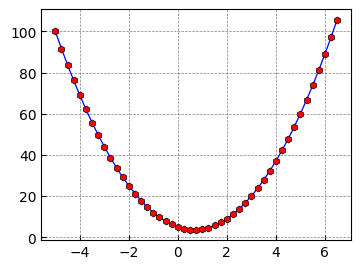

In [3]:
plt.figure(figsize=(4, 3))
x = np.arange(-5, 6.6, 0.25)
y = f(x)
plt.plot(x, y, color='b', linestyle='-', linewidth=0.9, marker='h', markerfacecolor='red', markersize=5, markeredgecolor='k', markeredgewidth=.5)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.tick_params(axis="both", which="both", direction="in")

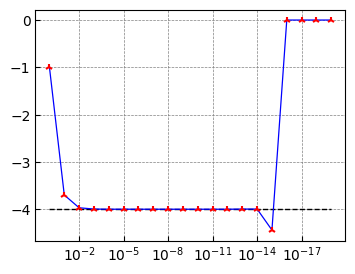

In [4]:
h = 0.0000001
x = 0.0

def der(x, h):
    return (f(x+h) - f(x))/h

plt.figure(figsize=(4, 3))
h = np.array([10**(-i) for i in range(20)])
y = der(x, h)
plt.hlines(-4, h[0], h[-1], 'k', linestyles='dashed', linewidth=1.0)
plt.semilogx(h, y, color='b', linestyle='-', linewidth=0.9, marker='2', markerfacecolor='red', markersize=5, markeredgecolor='r', markeredgewidth=1.5)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.gca().invert_xaxis()
plt.tick_params(axis="both", which="both", direction="in")

# Creating a basic Value class

# Topological sorting for flow of _backward()$ function

<!-- ![alt text](neuron_model.jpeg "Model of a neuron") -->
<img src="topo_sort.png" alt="Topological sorting" style="width:700px; border:0.4px solid black;"/>

In [5]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
            
        return out
        
    def __mul__(self, other):
        out =  Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
            
        return out
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1) 
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):

        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()

In [6]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a * b
e.label = 'e'

d = e + c
d.label = 'd'

f = Value(-2.0, label='f')

L = d * f
L.label = 'L'

d._prev, d._op

({Value(data=-6.0), Value(data=10.0)}, '+')

In [7]:
L.backward()

In [8]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """

    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    # Define colors for specific labels
    label_colors = defaultdict(lambda : 'white')
    label_colors[str(root.label)] = 'mintcream'
    
    for n in nodes:
        node_label = "%s \n| {data: %.2f } | {grad: %.2f}" % (n.label, n.data, n.grad)
        node_color = label_colors.get(n.label, label_colors[n.label])
        node_shape = 'record'
        dot.node(name=str(id(n)), label=node_label, shape=node_shape, style='filled', fillcolor=node_color)

        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op, style='filled', fillcolor='aliceblue')
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

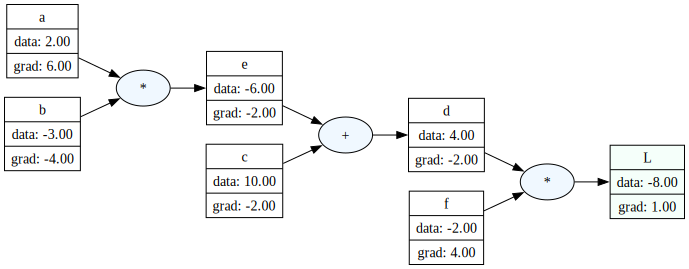

In [9]:
draw_dot(L)

# Simple forward step

In [10]:
h = 0.01
a.data += h * a.grad
b.data += h * b.grad 
c.data += h * c.grad 
f.data += h * f.grad 

e = a * b

L = d * f

L.data, a.grad, b.grad, c.grad, f.grad

(-7.84, 6.0, -4.0, -2.0, 4.0)

# Modeling a Neuron 

<!-- ![alt text](neuron_model.jpeg "Model of a neuron") -->
<img src="neuron_model.jpeg" alt="Model of a neuron" style="width:500px; border:0.4px solid black;"/>

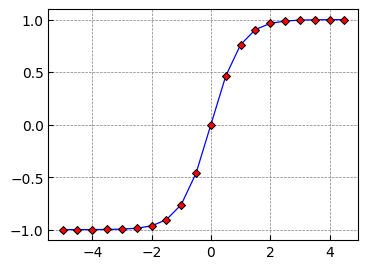

In [11]:
plt.figure(figsize=(4, 3))
x = np.arange(-5., 5., .5)
y = np.tanh(x)

plt.plot(x, y, color='b', linestyle='-', linewidth=0.9, marker='D', markerfacecolor='red', markersize=4, markeredgecolor='k', markeredgewidth=0.75)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.tick_params(axis="both", which="both", direction="in")

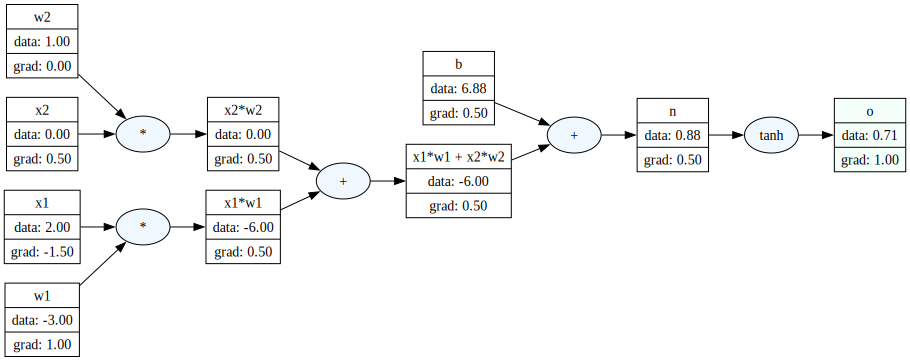

In [12]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.88137358, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

o.backward()

draw_dot(o)

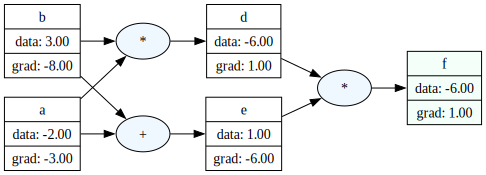

In [13]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')

d = a * b; d.label = 'd' 
e = a + b; e.label = 'e'

f = d * e; f.label = 'f'

f.backward()

draw_dot(f)